In [1]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"abdullahadel100","key":"c677bb6f3e1cea8bdb93561c96b772e2"}'}

In [2]:
!pip install kaggle
!kaggle datasets download -d smeschke/four-shapes

Dataset URL: https://www.kaggle.com/datasets/smeschke/four-shapes
License(s): CC0-1.0
 79% 17.0M/21.6M [00:00<00:00, 48.8MB/s]
100% 21.6M/21.6M [00:00<00:00, 57.5MB/s]


In [3]:
! unzip /content/four-shapes.zip

Streaming output truncated to the last 5000 lines.
  inflating: shapes/star/3234.png    
  inflating: shapes/star/3235.png    
  inflating: shapes/star/3236.png    
  inflating: shapes/star/3237.png    
  inflating: shapes/star/3238.png    
  inflating: shapes/star/3239.png    
  inflating: shapes/star/324.png     
  inflating: shapes/star/3240.png    
  inflating: shapes/star/3241.png    
  inflating: shapes/star/3242.png    
  inflating: shapes/star/3243.png    
  inflating: shapes/star/3244.png    
  inflating: shapes/star/3245.png    
  inflating: shapes/star/3246.png    
  inflating: shapes/star/3247.png    
  inflating: shapes/star/3248.png    
  inflating: shapes/star/3249.png    
  inflating: shapes/star/325.png     
  inflating: shapes/star/3250.png    
  inflating: shapes/star/3251.png    
  inflating: shapes/star/3252.png    
  inflating: shapes/star/3253.png    
  inflating: shapes/star/3254.png    
  inflating: shapes/star/3255.png    
  inflating: shapes/star/3256.png    

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from tqdm import tqdm

import tensorflow as tf
import keras
from keras.layers import Conv2D, Dropout, Embedding,  Flatten, Dense, BatchNormalization, Conv2DTranspose, Reshape, LeakyReLU
from keras.models import Sequential

In [92]:
Data_path ='/content/shapes'
labels =['circle', 'square', 'star', 'triangle']

circle : Class number 0 , that contain 3720 image


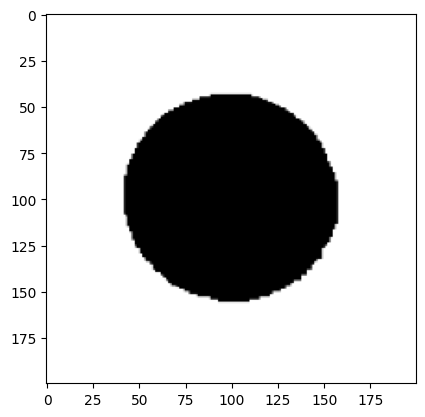

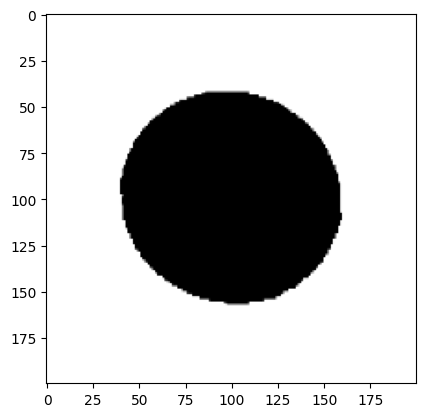

square : Class number 1 , that contain 3765 image


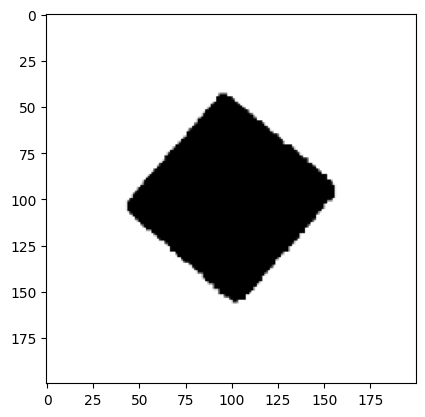

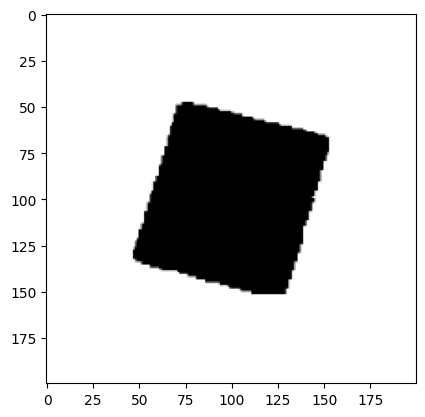

star : Class number 2 , that contain 3765 image


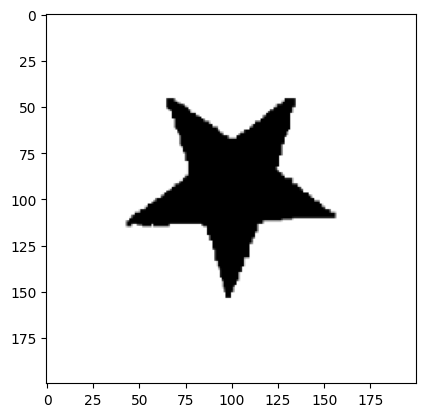

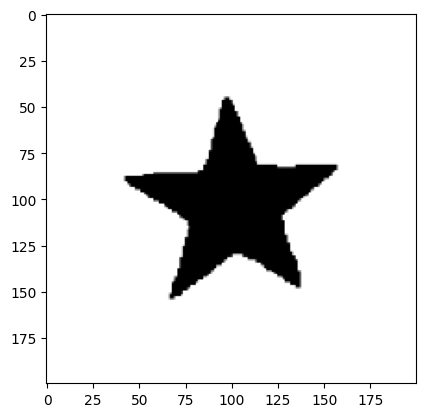

triangle : Class number 3 , that contain 3720 image


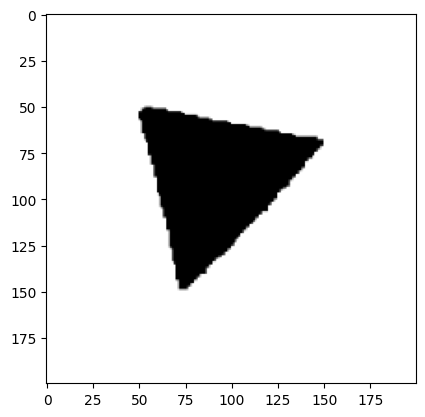

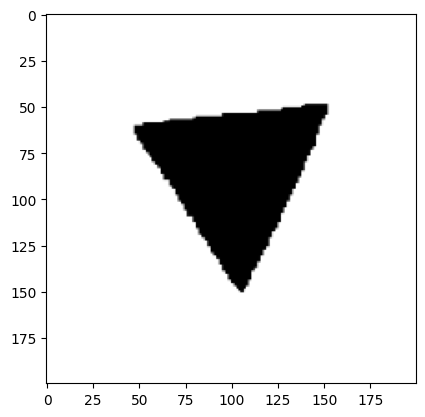

In [93]:
i =0
counts = {}

for label in labels :
    path =os.path.join(Data_path ,label)
    counts[label] = len(os.listdir(path))
    x =0
    print(f'{label} : Class number {i} , that contain {len(os.listdir(path))} image')
    for img in os.listdir(path):
        x +=1
        img =cv2.imread(os.path.join(path ,img) ,cv2.IMREAD_GRAYSCALE)
        plt.imshow(img ,cmap ='gray')
        plt.show()
        if x ==2 :
            print('==='*40)
            break
    i +=1

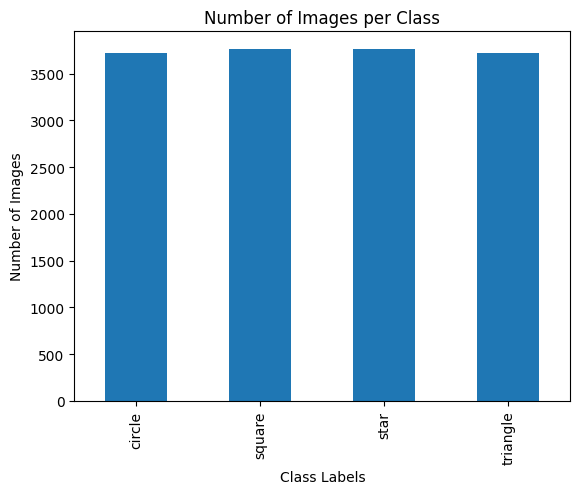

In [94]:
df = pd.DataFrame(list(counts.items()), columns=['Label', 'Count'])
df.set_index('Label', inplace=True)

df.plot(kind='bar', legend=False)

plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [95]:
img.shape

(200, 200)

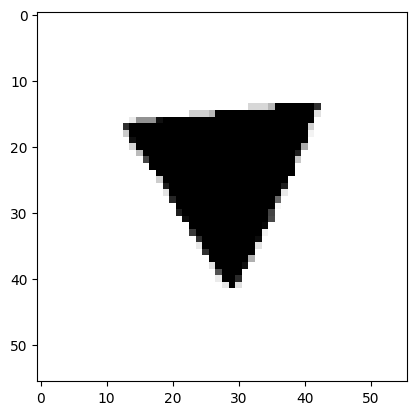

In [96]:
img_size =56

resized_img =cv2.resize(img ,(img_size ,img_size) ,1)
plt.imshow(resized_img ,cmap ='gray')
plt.show()

In [97]:
Data =[]

def creat_df(in_path ,data ):
    for label in labels :
        path =os.path.join(in_path ,label)
        class_num =labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                img = cv2.imread(os.path.join(path ,img) ,cv2.IMREAD_GRAYSCALE )
                img = (img - 127.5) / 127.5
                resized_img =cv2.resize(img ,(img_size ,img_size))
                data.append(resized_img )

            except exception as e:
                pass



creat_df(Data_path ,Data)

100%|██████████| 3720/3720 [00:01<00:00, 2966.28it/s]


In [98]:
noise_dim =100
epochs =160
BATCH_SIZE = 128
lambda_gp = 10

In [99]:
import random

random.shuffle(Data)

In [100]:
l =len(Data)
print(l * .8)

11976.0


In [101]:
Train = Data[:int(l * .8)]
Test =  Data[int(l * .8):]

print(len(Train))
print(len(Test))

11976
2994


In [102]:
Train = np.array(Train).reshape(-1, img_size, img_size, 1).astype('float32')
Test = np.array(Test).reshape(-1, img_size, img_size, 1).astype('float32')
Train.shape

(11976, 56, 56, 1)

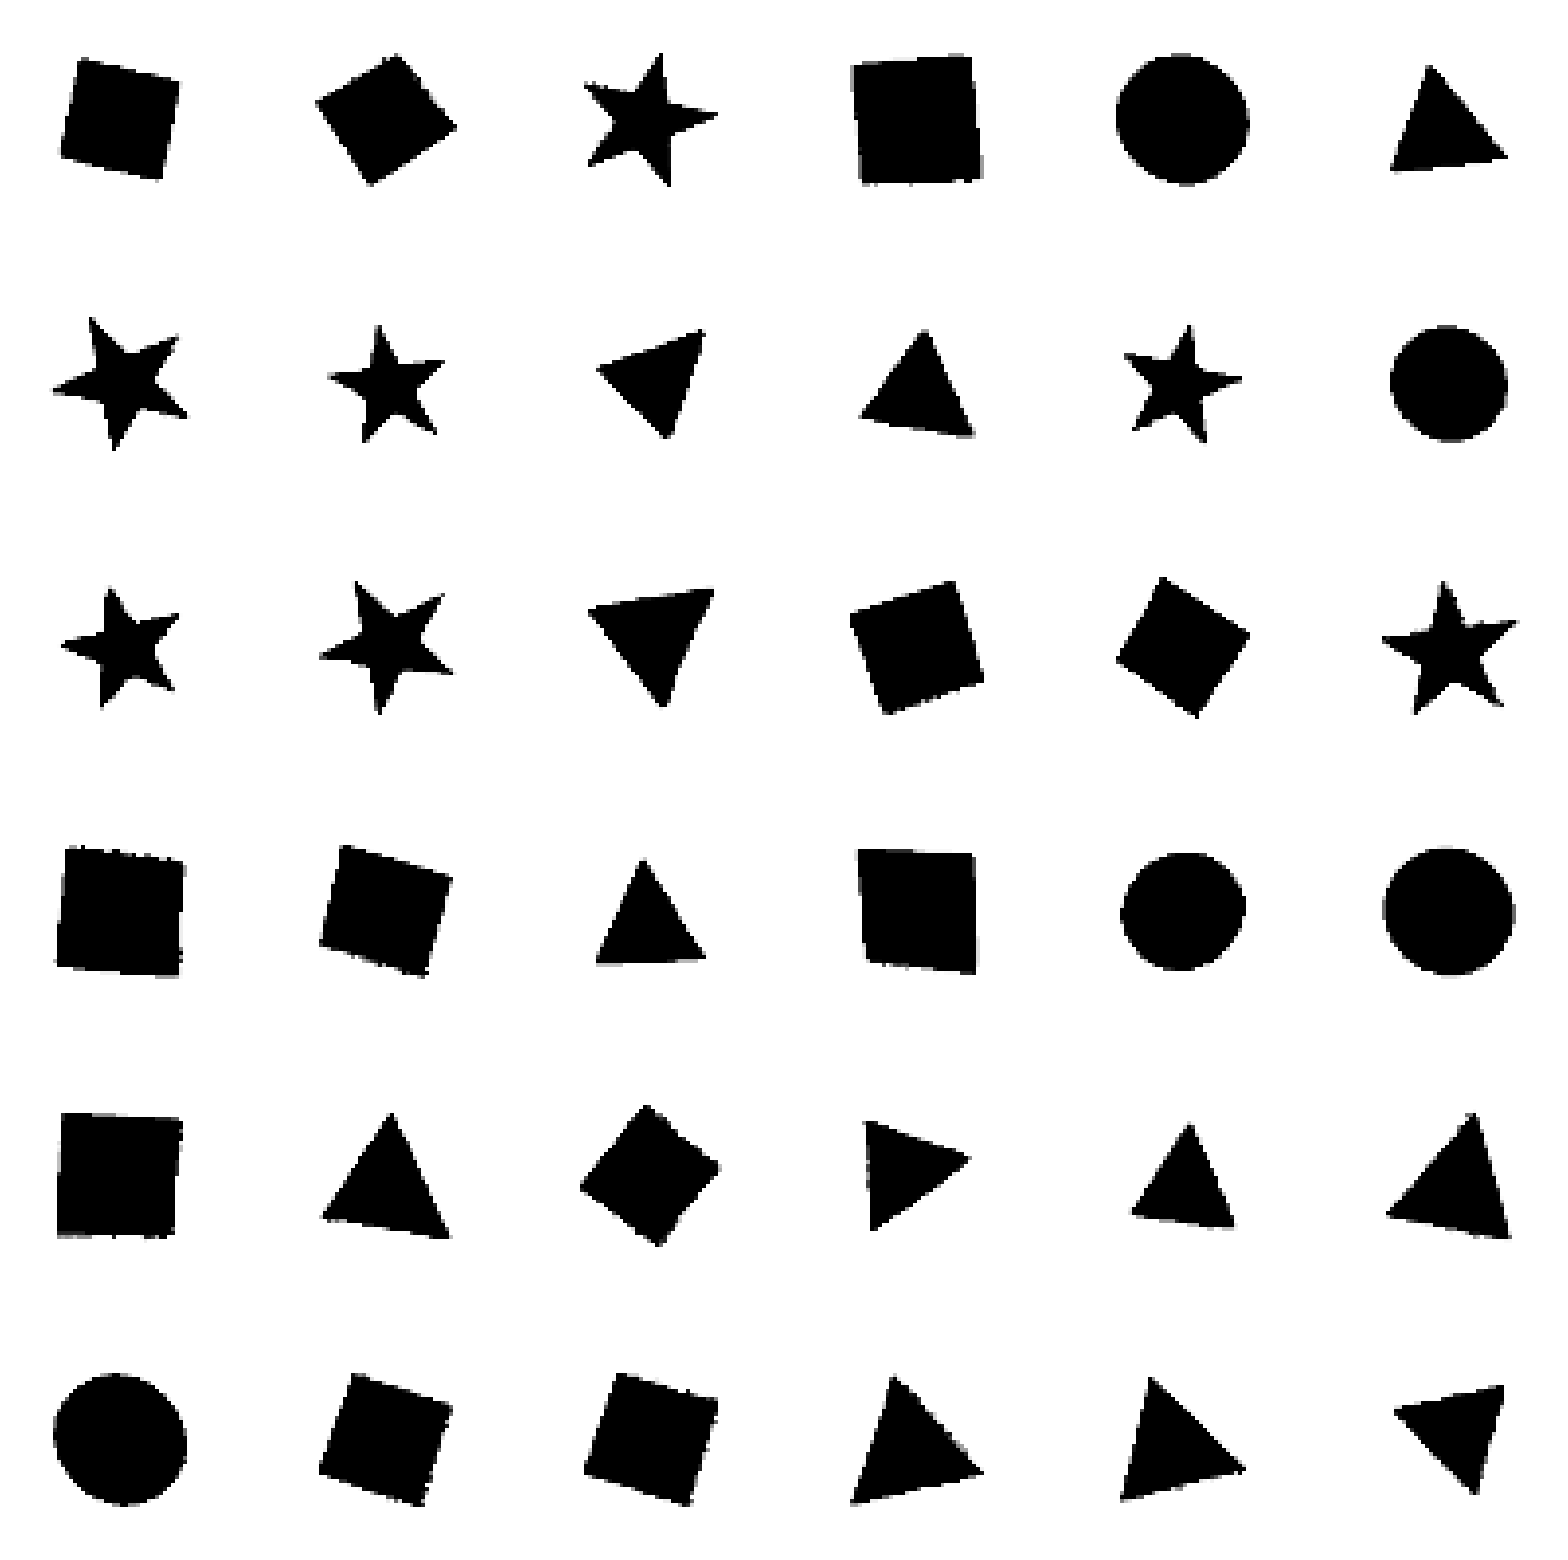

In [103]:
plt.figure(figsize=(20,20))

for n , i in enumerate(np.random.randint(0,len(Train),36)) :
    plt.subplot(6,6,n+1)
    plt.imshow(Train[i] ,cmap ='gray')
    plt.axis('off')


In [104]:
dataset = tf.data.Dataset.from_tensor_slices(Train)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

* Generator

In [105]:
def make_generator_model():
    model = Sequential([
        # Start with a dense layer and reshape to a smaller size
        Dense(7 * 7 * 256, use_bias=False, input_shape=(noise_dim,)),
        BatchNormalization(),
        LeakyReLU(),

        Reshape((7, 7, 256)),

        # Upsample to 14x14
        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        # Upsample to 28x28
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        # Upsample to 56x56
        Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        # Final layer: produce output with shape (56, 56, 1)
        Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'),
    ])
    return model

* Discriminator

In [106]:
def make_discriminator_model():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[img_size, img_size, 1]),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1)
    ])
    return model

In [107]:
#cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [108]:
def gradient_penalty(real_images, fake_images):
    epsilon = tf.random.uniform([real_images.shape[0], 1, 1, 1], dtype=real_images.dtype)
    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)
    gradients = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return penalty

In [109]:
def discriminator_loss(real_output, fake_output, gp):
    real_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
    total_loss = real_loss + lambda_gp * gp
    return total_loss


def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)



# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

In [110]:
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [111]:
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gp = gradient_penalty(images, fake_images)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, gp)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}", '=' * 40)
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
        print(f"Generator loss: {gen_loss:.4f}, Discriminator loss: {disc_loss:.4f}")

# Train the model
train(dataset, epochs)

Epoch 1/160 ========================================
Generator loss: -45.2831, Discriminator loss: -0.7018
Epoch 2/160 ========================================
Generator loss: -45.7007, Discriminator loss: 0.0423
Epoch 3/160 ========================================
Generator loss: -38.6706, Discriminator loss: -1.6334
Epoch 4/160 ========================================
Generator loss: -40.9330, Discriminator loss: -0.0083
Epoch 5/160 ========================================
Generator loss: -35.4100, Discriminator loss: -0.3499
Epoch 6/160 ========================================
Generator loss: -30.8103, Discriminator loss: 2.6724
Epoch 7/160 ========================================
Generator loss: -23.7484, Discriminator loss: -0.4946
Epoch 8/160 ========================================
Generator loss: -18.8338, Discriminator loss: 1.0349
Epoch 9/160 ========================================
Generator loss: -35.2252, Discriminator loss: 4.7605
Epoch 10/160 ============================

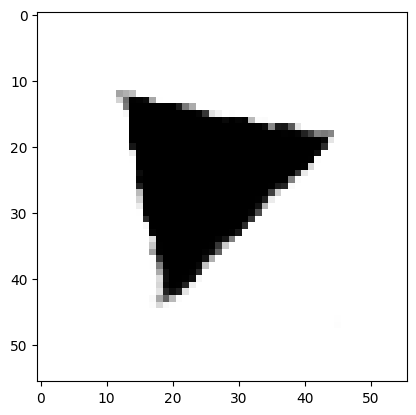

In [118]:
import matplotlib.pyplot as plt

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
reshaped_image = tf.reshape(generated_image, (img_size, img_size))  # Reshape using TensorFlow

plt.imshow(reshaped_image, cmap='gray')
plt.show()

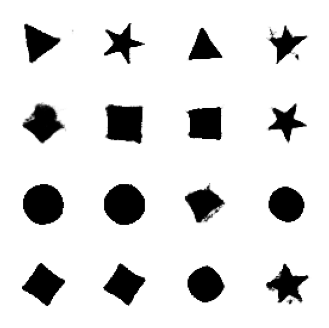

In [113]:
# Save the generator weights to a file
generator.save_weights('generator_weights.weights.h5')

# Load the generator weights from the file
generator.load_weights('generator_weights.weights.h5')

# Generate some fake images using the trained generator
noise = tf.random.normal([16, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Rescale the images from [-1, 1] to [0, 1] before displaying
    plt.imshow((generated_images[i] * 0.5 + 0.5).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

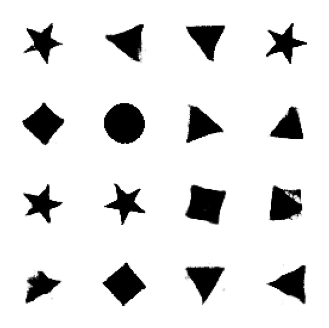

In [114]:
# Generate some fake images using the trained generator
noise = tf.random.normal([16, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Rescale the images from [-1, 1] to [0, 1] before displaying
    plt.imshow((generated_images[i] * 0.5 + 0.5).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

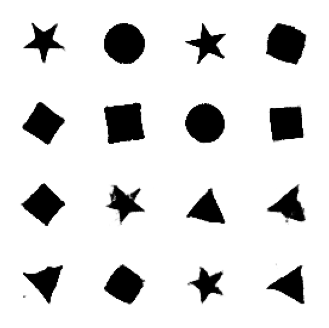

In [115]:
# Generate some fake images using the trained generator
noise = tf.random.normal([16, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Rescale the images from [-1, 1] to [0, 1] before displaying
    plt.imshow((generated_images[i] * 0.5 + 0.5).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

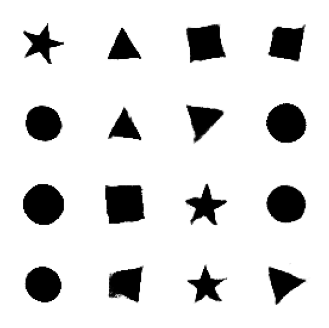

In [116]:
# Generate some fake images using the trained generator
noise = tf.random.normal([16, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Rescale the images from [-1, 1] to [0, 1] before displaying
    plt.imshow((generated_images[i] * 0.5 + 0.5).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

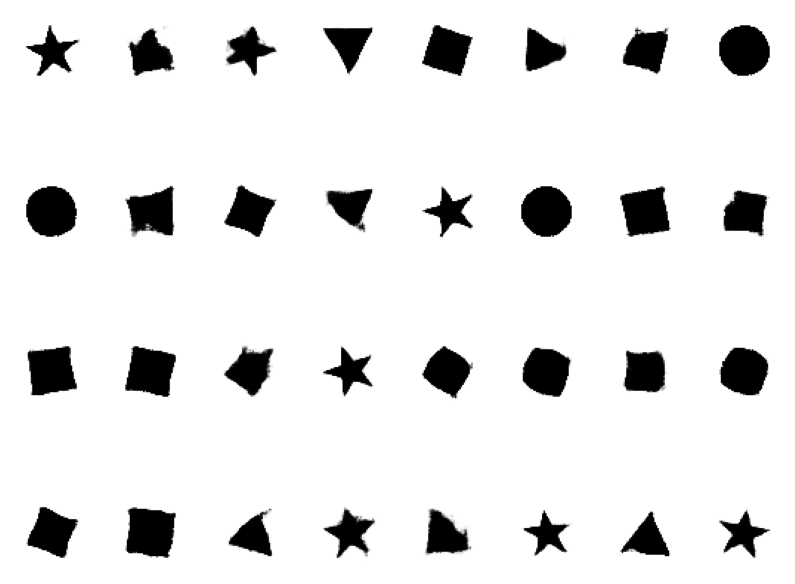

In [117]:
# Generate some fake images using the trained generator
noise = tf.random.normal([32, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(10, 8))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 8, i + 1)
    # Rescale the images from [-1, 1] to [0, 1] before displaying
    plt.imshow((generated_images[i] * 0.5 + 0.5).numpy(), cmap='gray')
    plt.axis('off')
plt.show()